In [44]:
import warnings, math
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import randint, uniform
import joblib

In [23]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [24]:
Data_PATH = "Downloads/Data.europe.eu/estat_isoc_ec_eseln2_en.csv"
CAP_ROWS  = 10_000
CV_FOLDS  = 3
TARGET    = "OBS_VALUE"

In [26]:
Data = pd.read_csv(Data_PATH, low_memory=True)

Data.head(5)

,DATAFLOW,LAST UPDATE,freq,size_emp,nace_r2,indic_is,unit,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,CONF_STATUS
0,ESTAT:ISOC_EC_ESELN2(1.0),17/07/25 11:00:00,A,GE10,C,E_AESBEU,PC_ENT,AT,2011,46.37,NaN,NaN
1,ESTAT:ISOC_EC_ESELN2(1.0),17/07/25 11:00:00,A,GE10,C,E_AESBEU,PC_ENT,BE,2011,30.23,NaN,NaN
2,ESTAT:ISOC_EC_ESELN2(1.0),17/07/25 11:00:00,A,GE10,C,E_AESBEU,PC_ENT,BE,2013,10.91,NaN,NaN
3,ESTAT:ISOC_EC_ESELN2(1.0),17/07/25 11:00:00,A,GE10,C,E_AESBEU,PC_ENT,BG,2011,3.73,NaN,NaN
4,ESTAT:ISOC_EC_ESELN2(1.0),17/07/25 11:00:00,A,GE10,C,E_AESBEU,PC_ENT,BG,2013,4.57,NaN,NaN


In [6]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761535 entries, 0 to 761534
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   DATAFLOW     761535 non-null  object 
 1   LAST UPDATE  761535 non-null  object 
 2   freq         761535 non-null  object 
 3   size_emp     761535 non-null  object 
 4   nace_r2      761535 non-null  object 
 5   indic_is     761535 non-null  object 
 6   unit         761535 non-null  object 
 7   geo          761535 non-null  object 
 8   TIME_PERIOD  761535 non-null  int64  
 9   OBS_VALUE    641685 non-null  float64
 10  OBS_FLAG     100557 non-null  object 
 11  CONF_STATUS  23713 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 69.7+ MB


In [27]:
Data.describe()

,TIME_PERIOD,OBS_VALUE
count,761535.000000,641685.000000
mean,2019.161641,28.963765
std,3.882851,30.563166
min,2009.000000,0.000000
25%,2017.000000,5.420000
50%,2020.000000,15.760000
75%,2022.000000,45.000000
max,2024.000000,102.160000


In [28]:
Data.shape

(761535, 12)

In [29]:
Data.dtypes

DATAFLOW        object
LAST UPDATE     object
freq            object
size_emp        object
nace_r2         object
indic_is        object
unit            object
geo             object
TIME_PERIOD      int64
OBS_VALUE      float64
OBS_FLAG        object
CONF_STATUS     object
dtype: object

In [30]:
Data.reset_index(drop=True, inplace=True)

In [31]:
Data.isna().sum()

DATAFLOW            0
LAST UPDATE         0
freq                0
size_emp            0
nace_r2             0
indic_is            0
unit                0
geo                 0
TIME_PERIOD         0
OBS_VALUE      119850
OBS_FLAG       660978
CONF_STATUS    737822
dtype: int64

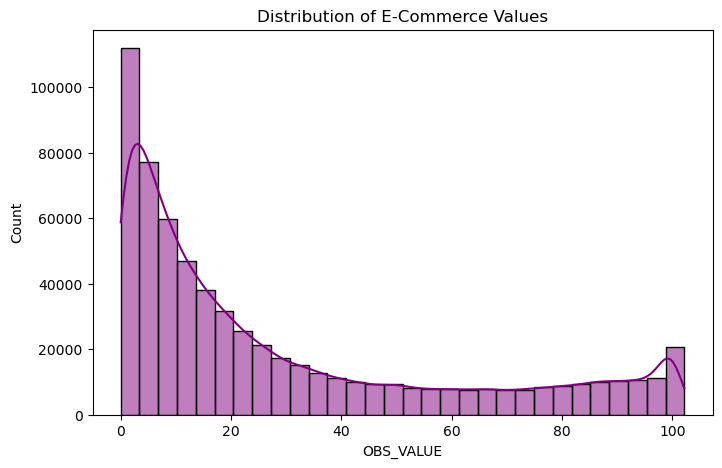

In [12]:
DF = Data[["freq", "size_emp", "nace_r2", "indic_is", "unit", "geo", "TIME_PERIOD", "OBS_VALUE"]]

plt.figure(figsize=(8,5))
sns.histplot(DF["OBS_VALUE"], bins=30, kde=True, color="purple")
plt.title("Distribution of E-Commerce Values")
plt.show()

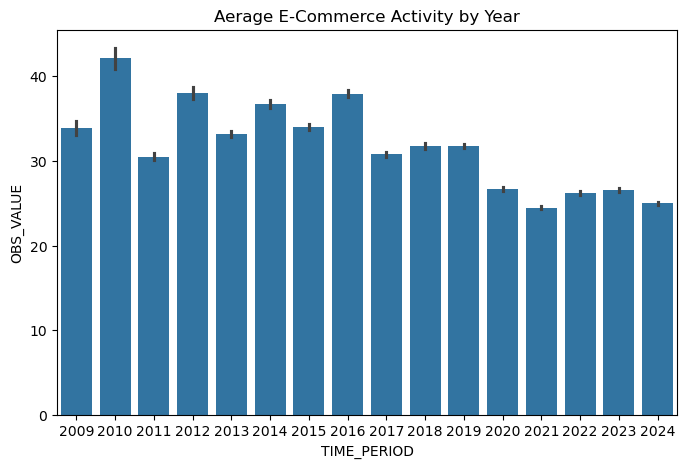

In [13]:
plt.figure(figsize=(8,5))
sns.barplot(x="TIME_PERIOD", y="OBS_VALUE", data=DF, estimator=np.mean)
plt.title("Aerage E-Commerce Activity by Year")
plt.show()

In [33]:
keep_cols = ["freq", "size_emp", "nace_r2", "indic_is", "unit", "geo", "TIME_PERIOD", "OBS_VALUE"]
Data = Data[keep_cols].copy()


Data[TARGET] = pd.to_numeric(Data[TARGET], errors="coerce")
Data = Data.dropna(subset=[TARGET])

print("Raw rows:", len(Data))

Raw rows: 641685


In [34]:
if len(Data) > CAP_ROWS:
    qbins = min(10, max(2, len(Data)//2000))
    bins = pd.qcut(Data[TARGET], q=qbins, duplicates="drop")
    Data = (
        Data.groupby(bins, group_keys=False)
            .apply(lambda x: x.sample(frac=CAP_ROWS/len(Data), random_state=RANDOM_STATE)
                  if len(x) > 0 else x)
            .sample(n=CAP_ROWS, random_state=RANDOM_STATE)
            .reset_index(drop=True)
    )
    print("Capped rows:", len(Data))

Capped rows: 10000


In [35]:
if np.issubdtype(Data["TIME_PERIOD"].dtype, np.number):
    Data["year_bucket"] = (Data["TIME_PERIOD"] // 5) * 5
else:

    Data["TIME_PERIOD"] = pd.to_numeric(Data["TIME_PERIOD"], errors="coerce")
    Data["year_bucket"] = (Data["TIME_PERIOD"] // 5) * 5

In [36]:
DF = Data.copy()
X = DF.drop(columns=[TARGET])
y = DF[TARGET].copy()

num_cols = [c for c in X.columns if np.issubdtype(X[c].dtype, np.number)]
cat_cols = [c for c in X.columns if c not in num_cols]

print(f"num: {len(num_cols)} | cat: {len(cat_cols)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

num: 2 | cat: 6


In [38]:
pre_num = Pipeline([
    ("imp",   SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

pre_cat = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

pre = ColumnTransformer(
    transformers=[
        ("num", pre_num, num_cols),
        ("cat", pre_cat, cat_cols)
    ],
    remainder="drop"
)

In [39]:
LR = Pipeline(steps=[("pre", pre), ("model", LinearRegression())])

RF = Pipeline(steps=[
    ("pre", pre),
    ("model", RandomForestRegressor(
        n_estimators=150,     
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

GB = Pipeline(steps=[
    ("pre", pre),
    ("model", GradientBoostingRegressor(
        random_state=RANDOM_STATE
    ))
])


In [40]:
CV = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

def cv_rmse(pipe, X, y, cv=CV):
    s = cross_val_score(pipe, X, y, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1)
    return -s.mean(), s.std()

models = {"Linear Regression": LR, "Random Forest": RF, "Gradient Boosting": GB}

print("\n...... Baseline Model performance .....")
baseline_rows = []
for name, mdl in models.items():
    m, sd = cv_rmse(mdl, X_train, y_train)
    baseline_rows.append((name, m, sd))
    print(f"{name:18s} | CV RMSE: {m:6.3f} ± {sd:6.4f}")



...... Baseline Model performance .....
Linear Regression  | CV RMSE: 17.072 ± 0.1549
Random Forest      | CV RMSE: 13.281 ± 0.3242
Gradient Boosting  | CV RMSE: 15.050 ± 0.1275


In [45]:
rf_dist = {
    "model__n_estimators": randint(100, 200),
    "model__max_depth": randint(6, 16),
    "model__min_samples_split": randint(2, 10),
    "model__min_samples_leaf": randint(1, 5),
    "model__max_features": ["sqrt", "log2", 0.4, 0.6],
    "model__bootstrap": [True]
}
gb_dist = {
    "model__n_estimators": randint(110, 220),
    "model__learning_rate": uniform(0.04, 0.12),  # ~0.04–0.16
    "model__max_depth": randint(2, 5),
    "model__subsample": uniform(0.75, 0.25)       # ~0.75–1.0
}

GS_RF = RandomizedSearchCV(
    estimator=RF,
    param_distributions=rf_dist,
    n_iter=8,                             # tiny
    scoring="neg_root_mean_squared_error",
    cv=CV,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=0
)

GS_GB = RandomizedSearchCV(
    estimator=GB,
    param_distributions=gb_dist,
    n_iter=8,                             # tiny
    scoring="neg_root_mean_squared_error",
    cv=CV,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=0
)


GS_RF.fit(X_train, y_train)
print("\nRF best params:", GS_RF.best_params_, " | CV RMSE:", -GS_RF.best_score_)

GS_GB.fit(X_train, y_train)
print("GB best params:", GS_GB.best_params_, " | CV RMSE:", -GS_GB.best_score_)


RF best params: {'model__bootstrap': True, 'model__max_depth': 12, 'model__max_features': 0.6, 'model__min_samples_leaf': 1, 'model__min_samples_split': 8, 'model__n_estimators': 171}  | CV RMSE: 14.283871678967197
GB best params: {'model__learning_rate': np.float64(0.11183901810364438), 'model__max_depth': 4, 'model__n_estimators': 192, 'model__subsample': np.float64(0.7749937289545007)}  | CV RMSE: 13.456014442852352


In [46]:
def evaluate_model(name, y_true, y_pred):
    R2   = r2_score(y_true, y_pred)
    RMSE = math.sqrt(mean_squared_error(y_true, y_pred))
    MAE  = mean_absolute_error(y_true, y_pred)
    print(f"{name}:  R2 = {R2:.3f},  RMSE = {RMSE:.3f},  MAE = {MAE:.3f}"

LR.fit(X_train, y_train)
RF.fit(X_train, y_train)
GB.fit(X_train, y_train)

LR_Pred = LR.predict(X_test)
RF_Pred = RF.predict(X_test)
GB_Pred = GB.predict(X_test)

print("\n--- Baseline (Hold-out Test) ---")
evaluate_model("Linear Regression", y_test, LR_Pred)
evaluate_model("Random Forest",     y_test, RF_Pred)
evaluate_model("Gradient Boosting", y_test, GB_Pred)


RF_Pred_Tuned = GS_RF.predict(X_test)
GB_Pred_Tuned = GS_GB.predict(X_test)

print("\n--- Tuned Models (Hold-out Test) ---")
evaluate_model("Random Forest (tuned)",     y_test, RF_Pred_Tuned)
evaluate_model("Gradient Boosting (tuned)", y_test, GB_Pred_Tuned)


RMSE_RF = math.sqrt(mean_squared_error(y_test, RF_Pred_Tuned))
RMSE_GB = math.sqrt(mean_squared_error(y_test, GB_Pred_Tuned))

if RMSE_RF <= RMSE_GB:
    best_grid_name = "Random Forest (tuned)"
    y_pred_best = RF_Pred_Tuned
else:
    best_grid_name = "Gradient Boosting (tuned)"
    y_pred_best = GB_Pred_Tuned

print(f"\n✅ Best tuned model: {best_grid_name}")


--- Baseline (Hold-out Test) ---
Linear Regression:  R2 = 0.711,  RMSE = 16.693,  MAE = 13.233
Random Forest:  R2 = 0.846,  RMSE = 12.203,  MAE = 7.639
Gradient Boosting:  R2 = 0.775,  RMSE = 14.731,  MAE = 10.681

--- Tuned Models (Hold-out Test) ---
Random Forest (tuned):  R2 = 0.810,  RMSE = 13.530,  MAE = 9.466
Gradient Boosting (tuned):  R2 = 0.829,  RMSE = 12.837,  MAE = 8.723

✅ Best tuned model: Gradient Boosting (tuned)


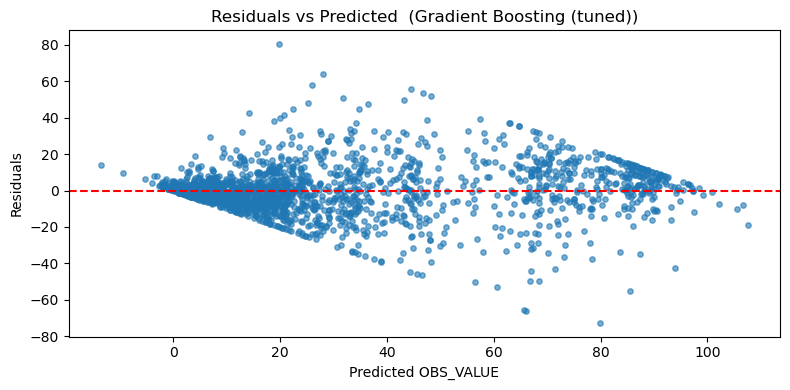

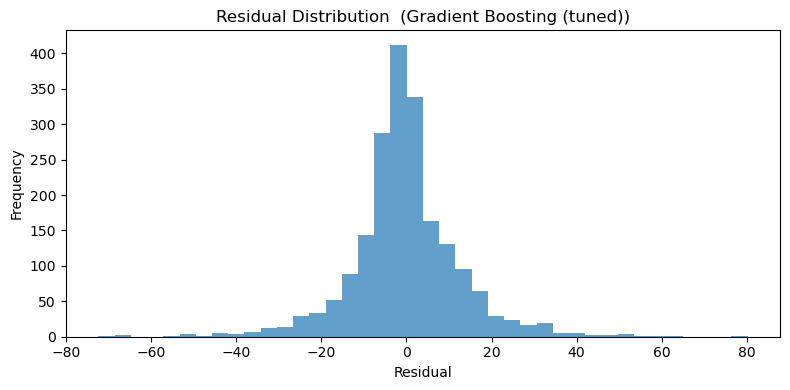

Mean residual      : -0.2941
Std deviation      : 12.8371
Min residual       : -72.4531
Max residual       : 80.1930


In [47]:
residuals = y_test - y_pred_best

plt.figure(figsize=(8,4))
plt.scatter(y_pred_best, residuals, s=15, alpha=0.6)
plt.axhline(0, ls="--", color="red")
plt.title(f"Residuals vs Predicted  ({best_grid_name})")
plt.xlabel("Predicted OBS_VALUE"); plt.ylabel("Residuals")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.hist(residuals, bins=40, alpha=0.7)
plt.title(f"Residual Distribution  ({best_grid_name})")
plt.xlabel("Residual"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()

print(f"Mean residual      : {residuals.mean():.4f}")
print(f"Std deviation      : {residuals.std():.4f}")
print(f"Min residual       : {residuals.min():.4f}")
print(f"Max residual       : {residuals.max():.4f}")

In [49]:
best_pipe = GS_GB.best_estimator_ if 'Gradient Boosting' in best_grid_name else GS_RF.best_estimator_

os.makedirs("artifacts", exist_ok=True)
MODEL_PATH = "artifacts/obs_value_model.joblib"
joblib.dump(best_pipe, MODEL_PATH)


train_columns = ["freq","size_emp","nace_r2","indic_is","unit","geo","TIME_PERIOD"]  
joblib.dump({"columns": train_columns}, "artifacts/metadata.joblib")

print(f"Saved model to: {MODEL_PATH}")

Saved model to: artifacts/obs_value_model.joblib
